#### Reference:
- https://learn.deeplearning.ai/courses/building-coding-agents-with-tool-execution/

# Overview: 
- Running code using E2B sandbox in the cloud ⛅

![alt](media/agent.png)


First start by filtering warnings and loading environment variables.

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from helper import load_env
load_env()

You can create a sandbox with E2B by using `Sandbox.create` and giving it a timeout. Then you can run code by simply using the `run_code` method. Try it out below.

In [2]:
from e2b_code_interpreter import Sandbox

sbx = Sandbox.create(timeout=60 * 60)
sbx.run_code("print('hello world')")

Execution(Results: [], Logs: Logs(stdout: ['hello world\n'], stderr: []), Error: None)

In [3]:
sbx.run_code("a=5\na")

Execution(Results: [Result(5)], Logs: Logs(stdout: [], stderr: []), Error: None)

In [4]:
sbx.run_code("console.log('Hello, world!')", language="javascript")

Execution(Results: [], Logs: Logs(stdout: ['Hello, world!\n'], stderr: []), Error: None)

### Creating plots

You can create plots by running code with `matplotlib`. You can display the results from the sandbox after running the code.

In [5]:
code = """import matplotlib.pyplot as plt
import numpy as np

x = np.random.randn(100)
y = np.random.randn(100)

plt.scatter(x, y, alpha=0.7)
plt.title('Random Scatter')
plt.show()"""

execution = sbx.run_code(code)

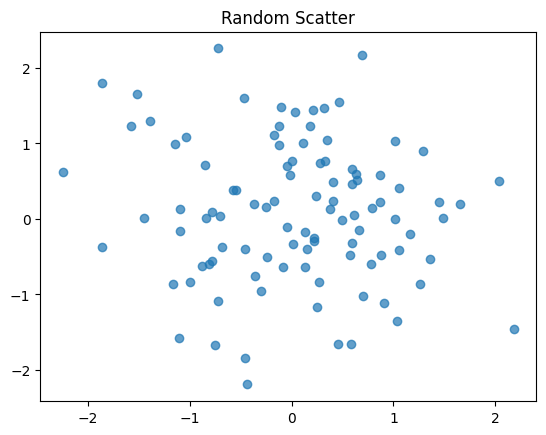

In [6]:
from IPython.display import Image, display
import base64

display(Image(data=base64.b64decode(execution.results[0].png)))

### Listing Sandboxes

You can list sandboxes and get important information about the sandboxes. Note that the sandbox IDs are unique to the user who created them and will differ from those in the video.

In [7]:
running_sandboxes = Sandbox.list().next_items()
f"""Running sandboxes with ids = {[
    sbx.sandbox_id for sbx in running_sandboxes
]}"""

"Running sandboxes with ids = ['i1x1dplomtx3p1j3aldra', 'irwuziucxrg5z08fwh0jp']"

In [8]:
running_sandbox = running_sandboxes[0]

print("Running sandbox metadata:", running_sandbox.metadata)
print("Running sandbox id:", running_sandbox.sandbox_id)
print("Running sandbox started at:", running_sandbox.started_at)
print("Running sandbox template id:", running_sandbox.template_id)

Running sandbox metadata: {}
Running sandbox id: i1x1dplomtx3p1j3aldra
Running sandbox started at: 2026-01-16 12:54:58.110187+00:00
Running sandbox template id: nlhz8vlwyupq845jsdg9


### Querying Sandboxes
By attaching metadata, you can query the sandbox and find them.

In [9]:
from e2b_code_interpreter import Sandbox, SandboxQuery, SandboxState

sbx = Sandbox.create(
    metadata={
        "name": "find me!",
    }
)


running_sandboxes = Sandbox.list(SandboxQuery(
        metadata={
            "name": "find me!",
        },
        state=[SandboxState.RUNNING])
)

f"""Found sandboxes with ids = {[
    sbx.sandbox_id for sbx in running_sandboxes.next_items()
]}"""

"Found sandboxes with ids = ['ix5b8wszp3me192mv0hct']"

### Working with files
E2B sandboxes have a file system and you can create directories, write to file, read files, and remove files.

In [10]:
sbx = Sandbox.create()
sbx.files.make_dir("/home/user/data")

True

In [11]:
sbx.files.write("/home/user/data/hello.txt", "Hello from the sandbox")

WriteInfo(name='hello.txt', type='file', path='/home/user/data/hello.txt')

In [12]:
content = sbx.files.read("/home/user/data/hello.txt")
content

'Hello from the sandbox'

In [13]:
sbx.files.remove("/home/user/data/hello.txt")

### Caching sandboxes

Using `create_sandbox` allows you to create a sandbox if it does not exist. If you call it again, it will reconnect to it.

In [14]:
from lib.utils import create_sandbox

sbx = create_sandbox()

INFO     [sandbox] 🚀 Creating new Sandbox.create(id=id9sj16wqrr0vp7qkegtd)

In [15]:
sbx = create_sandbox()

INFO     [sandbox] 🔌 Reconnecting to Sandbox.create(id=id9sj16wqrr0vp7qkegtd)

### Websites

You can also run websites from the sandbox by creating an `index.html` file and serving the file.

In [16]:
from lib.utils import create_sandbox

sbx = create_sandbox()

simple_website = """<!DOCTYPE html>
<html>
<head><title>Test Site</title></head>
<body><h1>Hello World from the Sandbox :)</h1></body>
</html>"""

sbx.files.write("index.html", simple_website)

INFO     [sandbox] 🔌 Reconnecting to Sandbox.create(id=id9sj16wqrr0vp7qkegtd)

WriteInfo(name='index.html', type='file', path='/home/user/index.html')

In [17]:
command = sbx.commands.run("python -m http.server 3000 --bind 0.0.0.0", background=True)
host = sbx.get_host(3000)

In [18]:
from IPython.display import IFrame

IFrame(f"https://{host}/index.html", width=800, height=300)

## Running code on the cloud

You can modify your previous `execute_code` function to use the `run_code` method from your sandbox. This will allow it to execute code in the sandbox environment instead of locally as before.

In [19]:
from e2b_code_interpreter import Execution, Sandbox
from typing import Tuple


def execute_code(code: str, sbx: Sandbox) -> Tuple[Execution, dict]:
    metadata = {}
    execution = sbx.run_code(code)
    return execution.to_json(), {}

tools = {"execute_code": execute_code}

In [20]:
from lib.tools_schemas import execute_code_schema
from lib.coding_agent import coding_agent, log
from openai import OpenAI

client = OpenAI()

sbx = create_sandbox()

system = """
You are a senior python programmer. 
You must run the code using the `execute_code` tool."""

_ = log(coding_agent,
    client,
    sbx,
    "Make and run a function to roll a 6 faces dice",
    system=system,
    tools=tools,
    tools_schemas=[execute_code_schema],
)

INFO     [sandbox] 🔌 Reconnecting to Sandbox.create(id=id9sj16wqrr0vp7qkegtd)

╭───────────────────────────────────────────────── 🤖 Tool Call ──────────────────────────────────────────────────╮
│ execute_code                                                                                                    │
│ Arguments: {"code":"import random\n\ndef roll_dice():\n    return random.randint(1, 6)\n\n# Roll the            │
│ dice\nroll_result = roll_dice()\nroll_result"}                                                                  │
│ Result: {"results": [{"text": "6"}], "logs": "{\"stdout\": [], \"stderr\": []}", "error": null}                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO     ✨: I have created a function called `roll_dice` that simulates rolling a 6-faced dice and ran it. The    
         result of the roll was 6. If you want, I can roll it again or show you the code.

INFO     [agent] 🔢 tokens: 234 total

In [21]:
query = """Create file.txt with 'hello world' inside, 
then read and print back its content.
"""
_ = log(coding_agent,
    client,
    sbx,
    query,
    system=system,
    tools=tools,
    tools_schemas=[execute_code_schema],
)

╭───────────────────────────────────────────────── 🤖 Tool Call ──────────────────────────────────────────────────╮
│ execute_code                                                                                                    │
│ Arguments: {"code":"with open('file.txt', 'w') as file:\n    file.write('hello world')\n\nwith open('file.txt', │
│ 'r') as file:\n    content = file.read()\n\nprint(content)"}                                                    │
│ Result: {"results": [], "logs": "{\"stdout\": [\"hello world\\n\"], \"stderr\": []}", "error": null}            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO     ✨: I have created the file named "file.txt" with 'hello world' inside, then read and printed its content.
         The output is:                                                                                            
                                                                                                                   
         hello world

INFO     [agent] 🔢 tokens: 234 total

You can even do more complex tasks like creating a minimalist snake game using just HTML and JavaScript and then serving that from the sandbox. Note that this can take around 3-4 minutes to complete.

In [22]:
query = """Create a minimalist Snake game and save it into index.html.
It must have the following features:
- 10x10 grid (CSS Grid or Canvas)
- Arrow keys for movement
- Food spawns randomly
- Snake grows when eating
- Game over on wall/self collision
- Simple score counter
- Restart button
- Retro green-on-black styling
- Pure vanilla JS, no libs
- Snake speed is 4 block per second
- Use random food emoji for food
"""

sbx = create_sandbox()
_ = log(coding_agent,
    client,
    sbx,
    query,
    system=system,
    tools=tools,
    tools_schemas=[execute_code_schema],
    model="gpt-5-mini",
)

INFO     [sandbox] 🔌 Reconnecting to Sandbox.create(id=id9sj16wqrr0vp7qkegtd)

INFO     ✨: [agent-#0] Thinking...

INFO      ...

╭───────────────────────────────────────────────── 🤖 Tool Call ──────────────────────────────────────────────────╮
│ execute_code                                                                                                    │
│ Arguments: {"code":"html = r'''<!doctype html>\n<html lang=\"en\">\n<head>\n<meta charset=\"utf-8\" />\n<meta   │
│ name=\"viewport\" content=\"width=device-width,initial-scale=1\" />\n<title>Minimalist Snake</title>\...        │
│ Result: {"results": [{"text": "Wrote index.html"}], "logs": "{\"stdout\": [], \"stderr\": []}", "error": null}  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO     ✨: Saved index.html with the minimalist Snake game (10x10, arrow keys, random emoji food, grows,         
         collisions, score, restart, retro green-on-black, 4 blocks/sec).                                          
                                                                                                                   
         Open index.html in your browser to play.

INFO     [agent] 🔢 tokens: 3218 total

Now you can start a server on the sandbox and access the game online.

In [23]:
command = sbx.commands.run("python -m http.server 3000 --bind 0.0.0.0", background=True)

host = sbx.get_host(3000)
IFrame(f"https://{host}/index.html", width=800, height=800)

Alternatively, you could run this locally on your own computer by running the cell below, downloading `index.html` file, and then running it in your own browser.

In [24]:
content = sbx.files.read("/home/user/index.html")

with open("index.html", "w") as f:
    f.write(content)